In [31]:
# Importing Libraries
'''Main'''
import numpy as np
import pandas as pd
import glob, os, re, time

'''Data Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn import preprocessing as pp

'''Clustering Models'''
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

'''Model Evaluation'''
from sklearn.metrics import adjusted_rand_score, silhouette_score

'''Dimensionality Reduction Algorithms'''
from sklearn.decomposition import PCA


# Data

In [3]:
files = glob.glob(os.path.join('data', '*.zip'))
data = pd.concat((pd.read_csv(file, compression='zip', header=1, low_memory=False) for file in files), ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518115 entries, 0 to 518114
Columns: 150 entries, id to settlement_term
dtypes: float64(112), object(38)
memory usage: 592.9+ MB


In [4]:
data.shape

(518115, 150)

In [5]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

I don't really need all these columns, so we'll narrow them down.

In [6]:
print('old shape: ', data.shape)
# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]
print('new shape: ', data.shape)

old shape:  (518115, 150)
new shape:  (518115, 37)


- **loan_amnt** : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- **funded_amnt** : The total amount committed to that loan at that point in time.
- **funded_amnt_inv** : The total amount committed by investors for that loan at that point in time.
- **term** : The number of payments on the loan. Values are in months and can be either 36 or 60.
- **int_rate** : Interest Rate on the loan
- **installment** : The monthly payment owed by the borrower if the loan originates.
- **grade** : LC assigned loan grade
- **sub_grade** : LC assigned loan subgrade
- **emp_length** : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- **home_owndership** : The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER. 
- **annual_inc** : The self-reported annual income provided by the borrower during registration.
- **verification_status** : The status of the loan during the listing period. Values: APPROVED, NOT_APPROVED.
- **pymnt_plan** : Indicates if a payment plan has been put in place for the loan
- **purpose** : A category provided by the borrower for the loan request. 
- **addr_state** : The state provided by the borrower in the loan application
- **dti** : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- **delinq_2yrs** : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- **earliest_cr_line** : The date the borrower's earliest reported credit line was opened
- **mths_since_last_delinq** : The number of months since the borrower's last delinquency.
- **mths_since_last_record** : The number of months since the last public record.
- **open_acc** : The number of open credit lines in the borrower's credit file.
- **pub_rec** : Number of derogatory public records
- **revol_bal** : Total credit revolving balance
- **revol_util** : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- **total_acc** : The total number of credit lines currently in the borrower's credit file
- **initial_list_status** : The initial listing status of the loan. Possible values are – W, F
- **out_prncp** : Remaining outstanding principal for total amount funded
- **out_prncp_inv** : Remaining outstanding principal for portion of total amount funded by investors
- **total_pymnt** : Payments received to date for total amount funded
- **total_pymnt_inv** : Payments received to date for portion of total amount funded by investors
- **total_rec_prncp** : Principal received to date
- **total_rec_int** : Interest received to date
- **total_rec_late_fee** : Late fees received to date
- **recoveries** : post charge off gross recovery
- **collection_recovery_fee** : post charge off collection fee
- **last_pymnt_d** : Last month payment was received
- **last_pymnt_amnt** : Last total payment amount received

In [7]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,5000.0,36 months,13.90%,170.65,C,C1,NaN,OWN,...,3164.76,2552.03,2552.03,1835.24,716.79,0.0,0.0,0.0,Jun-2020,170.65
1,6500.0,6500.0,6475.0,36 months,8.81%,206.13,A,A5,10+ years,OWN,...,0.00,7015.28,6988.30,6500.00,515.28,0.0,0.0,0.0,Apr-2020,4754.21
2,24000.0,24000.0,24000.0,60 months,13.90%,557.20,C,C1,10+ years,MORTGAGE,...,20427.69,7206.53,7206.53,3572.31,3634.22,0.0,0.0,0.0,Jun-2020,557.20
3,18500.0,18500.0,18500.0,60 months,14.74%,437.60,C,C2,NaN,MORTGAGE,...,15121.23,6533.70,6533.70,3378.77,3154.93,0.0,0.0,0.0,Jul-2020,437.60
4,24000.0,24000.0,24000.0,60 months,20.00%,635.86,D,D2,8 years,MORTGAGE,...,20017.99,9484.57,9484.57,3982.01,5502.56,0.0,0.0,0.0,Jun-2020,635.86


In [8]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                       8
funded_amnt                     8
funded_amnt_inv                 8
term                            8
int_rate                        8
installment                     8
emp_length                  46259
annual_inc                      8
dti                          1153
delinq_2yrs                     8
mths_since_last_delinq     292561
mths_since_last_record     462994
open_acc                        8
pub_rec                         8
revol_bal                       8
revol_util                    682
total_acc                       8
out_prncp                       8
out_prncp_inv                   8
total_pymnt                     8
total_pymnt_inv                 8
total_rec_prncp                 8
total_rec_int                   8
total_rec_late_fee              8
recoveries                      8
collection_recovery_fee         8
last_pymnt_amnt                 8
dtype: int64

In [9]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = SimpleImputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

# Check for NaNs one last time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [10]:
# Feature engineering
# Typically ratios between loan amount, revolving balance, payments, 
# and the borrower's annual income
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

For some reason, issues were happening later on.  Found out some newly created columns were becoming 'null' aka positive infinity.

In [13]:
print('NaN in numericalFeats: ', np.any(np.isnan(data.loc[:,numericalFeats])))

print('NaN in newFeats: 'np.any(np.isnan(data.loc[:,newFeats])))

data.loc[:,newFeats].max()

In [15]:
print('old data shape: ', data.shape)
with pd.option_context('mode.use_inf_as_na', True):
    # Dropping the rows with nan  
    # (or inf) values 
    data.dropna(inplace=True)
    
print('NaN in numericalFeats: ', np.any(np.isnan(data.loc[:,numericalFeats])))

print('NaN in newFeats: 'np.any(np.isnan(data.loc[:,newFeats])))

print('new data shape: ', data.shape)

# Feature Selection and Scaling

In [18]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [19]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

### Labels

In [20]:
data.grade.value_counts(dropna=False)

A    165175
B    150906
C    121873
D     74726
E      3375
F        36
G        17
Name: grade, dtype: int64

I see the grades are imbalanced, but as this is unsupervised project, I have to assume we can't know.

In [21]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['C', 'A', 'D', 'B', 'E', 'G', 'F'], dtype=object)

In [22]:
# Fill missing labels if there are any
labels = labels.fillna(value="Z")

# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name='grade')

# Store as y_train
y_train = labels

In [23]:
# View the changes
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew.head(5)

,grade,grade
0,2.0,C
1,0.0,A
2,2.0,C
3,2.0,C
4,3.0,D
5,3.0,D
6,2.0,C
7,2.0,C
8,0.0,A
9,1.0,B


In [24]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,1285.583177
1.0,1286.537482
2.0,1288.398079
3.0,1290.670952
4.0,1243.752083
5.0,1351.028571
6.0,1209.294118


Now that we have X_train with all 34 numberical features and y_train with numerical loan grades (used only to validate the results).

Presumably, borrowers that are similar to each other and grouped together should have similar credit profiles.  Aka, their creditworthiness should be similar.

## Sampling 10,000

In [25]:
# Random sample of 10,000 out of ~510,000
np.random.seed(123)

indices = np.random.choice(data.shape[0],10000)
X = X_train.iloc[indices] / 255.0
y = y_train.iloc[indices]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print(X.shape, y.shape)

(10000, 34) (10000,)


# Models

In [27]:
# PCA Dimensionality Reduction
def pca_dr(n=2, X=X):
    time_start = time.time()
    return PCA(n_components=n).fit_transform(X)
    print('PCA done!  Time elapsed: {} seconds'.format(time.time()-time_start))
    
# tSNE Dimensionality Reduction
def tsne_dr(n=2, v=1, p=40, n_iter=300, X=X):
    time_start = time.time()
    return TSNE(n_components=n, verbose=v, perplexity=p, n_iter=n_iter).fit_transform(X)
    print('t-SNE done!  Time elapsed: {} seconds'.format(time.time()-time_start))
    
# UMAP Dimensionality Reduction
def umap_dr(n=5, d=0.3, m='correlation', X=X):
    time_start = time.time()
    return umap.UMAP(n_neighbors=n, min_dist=d, metric=m).fit_transform(X)
    print('UMAP done!  Time elapsed: {} seconds'.format(time.time()-time_start))

Let's run an experimet where K ranges from 10 to 30 and plot the results of the accuracy measure we defined.

<AxesSubplot:>

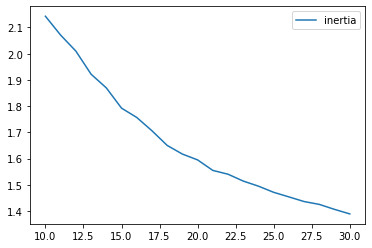

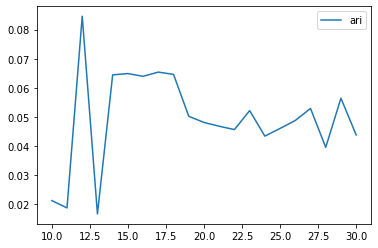

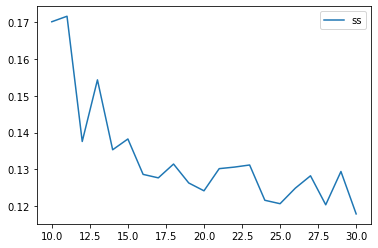

In [79]:
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 123
cluster_range = range(10,31)

kmeans = KMeans(n_clusters=n_clusters,
                n_init=n_init,
                max_iter=max_iter,
                tol=tol,
                random_state=random_state)
# Inertia
kMeans_inertia = pd.DataFrame(data=[],
                              index=cluster_range,
                              columns=['inertia'])
# ARI
ari_KMeansDF = pd.DataFrame(data=[],
                            index=cluster_range,
                            columns=['ari'])
# Silhouette Score
ss_KMeansDF = pd.DataFrame(data=[],
                            index=cluster_range,
                            columns=['ss'])
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters,
                    n_init=n_init,
                    max_iter=max_iter,
                    tol=tol,
                    random_state=random_state)
    kmeans.fit(X)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    cluster = kmeans.predict(X)
#     ypred = pd.DataFrame(data=cluster,
#                          index=X.index,
#                          columns=['cluster'])
    ari_KMeansDF.loc[n_clusters] = adjusted_rand_score(y, cluster)
    ss_KMeansDF.loc[n_clusters] = silhouette_score(X, cluster, metric='euclidean')
kMeans_inertia.plot()
ari_KMeansDF.plot()
ss_KMeansDF.plot()

Starting point to build a clustering application to automatically assign new borrowers that apply for a Lending Cllub loan into a pre-existing group based on how similar they are to the other borrowers.

In [65]:
inertia = [] # Inertia of kMeans
k = range(1, 20)
for i in k:
    means_k = KMeans(n_clusters=i, random_state=123)
    clusters = means_k.fit_transform(X)
    inertia.append(means_k.inertia_)
print('ARI :', adjusted_rand_score(y, clusters[:,0]))
print('Silhouette Score: ', silhouette_score(X, clusters[:,0], metric='euclidean'))

ARI : 9.637582431308861e-06
Silhouette Score:  0.017199999797743955


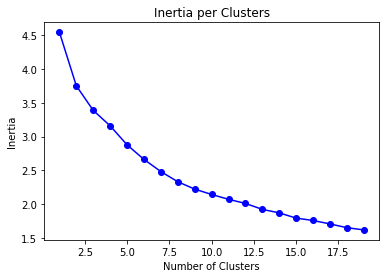

In [67]:
plt.plot(k, inertia, 'bo-')
plt.title('Inertia per Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.show()

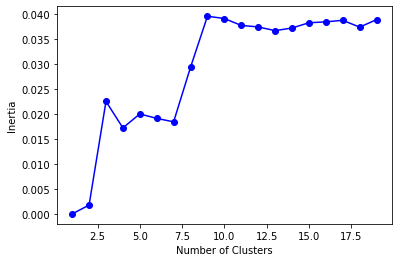

In [42]:
inertia = []
k = range(1,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity='cosine')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(adjusted_rand_score(y, clusters_agg))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

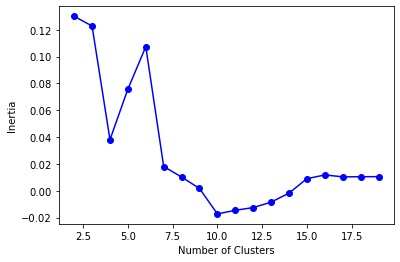

In [44]:
inertia = []
k = range(2,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity='cosine')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(silhouette_score(X, clusters_agg, metric='euclidean'))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

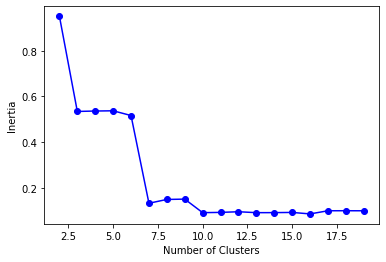

In [45]:
inertia = []
k = range(2,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity='manhattan')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(silhouette_score(X, clusters_agg, metric='euclidean'))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

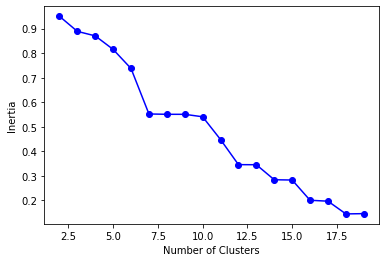

In [46]:
inertia = []
k = range(2,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity='euclidean')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(silhouette_score(X, clusters_agg, metric='euclidean'))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

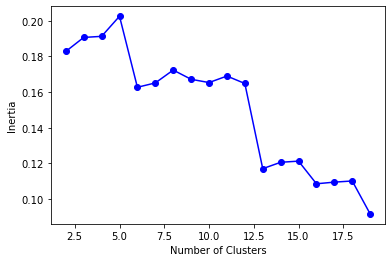

In [47]:
inertia = []
k = range(2,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='ward', affinity='euclidean')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(silhouette_score(X, clusters_agg, metric='euclidean'))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

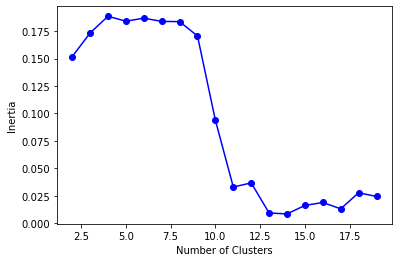

In [48]:
inertia = []
k = range(2,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='average', affinity='cosine')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(silhouette_score(X, clusters_agg, metric='euclidean'))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

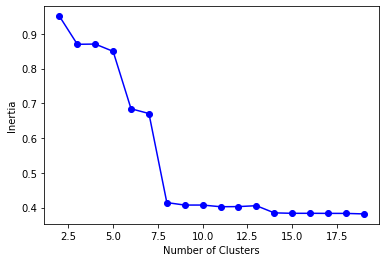

In [49]:
inertia = []
k = range(2,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='average', affinity='manhattan')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(silhouette_score(X, clusters_agg, metric='euclidean'))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

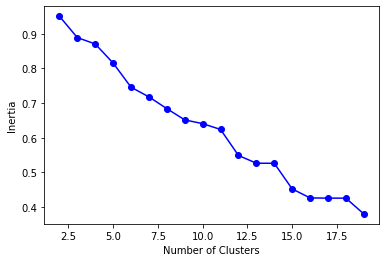

In [50]:
inertia = []
k = range(2,20)
for i in k:
    agg_model = AgglomerativeClustering(n_clusters=i, linkage='average', affinity='euclidean')
    clusters_agg = agg_model.fit_predict(X)
    inertia.append(silhouette_score(X, clusters_agg, metric='euclidean'))
    
#Plotting the elbow
plt.plot(k , inertia , 'bo-')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()